<img src="https://upload.wikimedia.org/wikipedia/en/a/a1/Visma_logo.jpg"
     align="right"
     width="30%"
     alt="Visma logo">
     
Bankcryptcy detection in Spark
================

<img src="http://www.rm.dk/siteassets/regional-udvikling/digitalisering/dabai/dabai-logo.png"
     align="right"
     width="20%"
     alt="DABAI logo">
     
     
The following notebook, shows a version of bankcruptcy detection in Apache Spark. 

In [1]:
%run -i initilization.py

#####  Data is imported to the notebook

The dataset consists of several attributes from the CVR dataset. The primary features are:
* 'AarsVaerk_x' is a feature for the amount of 'work' done in a year, where the smallest *x* represents the latest published Årsværk
* 'medArb_x is a feature for number of employees, where the smallest *x* represents the latest published Medarbejdstal
* rank_x indicates the latest value slope which can be either positive or negative

In [16]:
excludeCols = ["medArb_"+str(i) for i in range(1,16)] # we don't need the medarbejders 

df_import = (
    sqlContext
    .read
    .parquet(PATH+"/featureDataCvr.parquet")
)
#df.show()

list_include_cols = [i for i in df_import.columns if i not in excludeCols]
rankCols = [re.sub(
    pattern="rank_",
    repl="vaerdiSlope_",
    string=i) for i in list_include_cols]
list_finalCols = [F.col(i) for i in list_include_cols[:2]]+["kortBeskrivelse"]+[F.col(i).cast("double") for i in list_include_cols[2:] if i not in ["kortBeskrivelse"]]

rankCols = [re.sub(
    pattern="rank_",
    repl="vaerdiSlope_", string=i) for i in list_include_cols ]

df_renamed = (
    df_import
    .select(*list_finalCols)
    .select([F.col(val).alias(rankCols[idx]) for idx,val in enumerate(list_include_cols)])
    .filter((F.col("kortBeskrivelse") == "APS") | (F.col("kortBeskrivelse") == "AS"))
)

In [17]:
df_renamed.limit(5).toPandas()

,cvrNummer,status,label,AarsVaerk_1,AarsVaerk_2,AarsVaerk_3,AarsVaerk_4,AarsVaerk_5,AarsVaerk_6,AarsVaerk_7,...,totalLukketEnheder,vaerdiSlope_1,vaerdiSlope_2,vaerdiSlope_3,vaerdiSlope_4,vaerdiSlope_5,vaerdiSlope_6,vaerdiSlope_7,reklamebeskyttet,kortBeskrivelse
0,10043271,[NORMAL],0.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,...,1.0,36.843721,NaN,None,None,None,None,None,0.0,APS
1,10058511,"[OPLØST EFTER ERKLÆRING, NORMAL]",0.0,1.0,2.0,2.0,2.0,1.0,NaN,NaN,...,0.0,NaN,NaN,None,None,None,None,None,0.0,APS
2,10058511,"[OPLØST EFTER ERKLÆRING, NORMAL]",0.0,1.0,2.0,2.0,2.0,1.0,NaN,NaN,...,0.0,NaN,NaN,None,None,None,None,None,0.0,APS
3,10063027,"[TVANGSOPLØST, UNDER TVANGSOPLØSNING, NORMAL]",0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,105.021739,301.928571,None,None,None,None,None,0.0,APS
4,10063027,"[TVANGSOPLØST, UNDER TVANGSOPLØSNING, NORMAL]",0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,105.021739,301.928571,None,None,None,None,None,0.0,APS


The first 5 data points
============

The initial data contains many rows that are blank ie. NaN, which in this case means that the company was not active a that time.

##### Import  a company dataset

In [21]:
window_spec_rank =(
    Window
    .partitionBy(F.col("cvrNummer"))
    .orderBy(F.col("periode_gyldigFra").desc())
)

groupCols = ["cvrNummer","vaerdi"]
df_companies = (
    sqlContext
    .read
    .parquet(PATH+"/companyCvrData")
    .withColumn(colName="rank",col=F.rank().over(window_spec_rank))
    .filter((F.col("rank")==1) & (F.col("sekvensnr")==0))
    .select([F.col(i) for i in groupCols])
    .withColumnRenamed(existing="vaerdi",new="navn")
    .orderBy(F.col("cvrNummer"))
    .cache()
)

In [20]:
df_companies.limit(5).toPandas()

,cvrNummer,navn
0,10000009,YELLOW
1,10000025,WATERFRONT CONNECTION
2,10000068,"STUDENTCONSULTING, FILIAL AF SVERIGES STUDENTC..."
3,10000122,DIGITAL CENTER FYN
4,10000157,WITT INVEST


##### The data is cleaned
The data is cleaned such that we replace blanks with zeros, since a company can that hasn't existed ie a blank field, has not made any 'work' or number of employees.

In [22]:
list_label_cols = ["navn",
             "cvrNummer",
             "label",
             "status",
             "kortBeskrivelse"]
list_feat_cols = [i for i in df_companies.columns+df_renamed.columns if i not in list_label_cols]

#get minimum values from each column
#minCols = [F.min(i).alias(i) for i in featCols]
#minValsRdd = (renamedDf
#              .groupby()
#              .agg(*minCols)
#              .rdd)
#broadcastedmin = sc.broadcast(minValsRdd.first().asDict())

#NOTE USED! create array that subtracts minimum value in the numeric columns.
#logColsSelected = [F.col(i).alias(i) for i in labelCols]+[(F.col(i)-F.lit(broadcastedmin.value[i])).alias(i) for i in featCols]

#NOT USED! takes log(x+1) to the numeric columns and fills the blanks with 0.0 
df_merged_company_features = (df_renamed
         .join(df_companies, 'cvrNummer', 'inner')
         #.select(*logColsSelected)
         #.select([F.col(i).alias(i) for i in labelCols]+[F.log1p(F.col(i)).alias(i) for i in featCols])
         .distinct()
         .na
         .fill(0.0, list_feat_cols)
         .cache()
        )
df_merged_company_features.limit(5).toPandas()

,cvrNummer,status,label,AarsVaerk_1,AarsVaerk_2,AarsVaerk_3,AarsVaerk_4,AarsVaerk_5,AarsVaerk_6,AarsVaerk_7,...,vaerdiSlope_1,vaerdiSlope_2,vaerdiSlope_3,vaerdiSlope_4,vaerdiSlope_5,vaerdiSlope_6,vaerdiSlope_7,reklamebeskyttet,kortBeskrivelse,navn
0,10020824,[NORMAL],0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,TMC 2000
1,10022517,[NORMAL],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.306339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,BEHRENS SKOVBRUG
2,10029066,[NORMAL],0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,-9.576506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,DAUM HOLDING
3,10084369,"[OPLØST EFTER SPALTNING, NORMAL]",0.0,10.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,KM TELECOM SOLUTIONS
4,10100593,"[OPLØST EFTER ERKLÆRING, NORMAL]",0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,39.202875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,HVASAL RUSTFRI


### Build the pipeline model

The different steps for the [Spark's Pipeline](http://spark.apache.org/docs/2.0.0/ml-pipeline.html) are initialized. 
The steps in the ML-pipeline are:
* Vectorization, data is arranged as a vector containing features.
* Standardization with mean and standard deviation.
* Machine Learning model training and optimization, we need to find the best model.


In [23]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# sort out the lables
set_label_cols = set(list_label_cols)

list_merged_feature_cols = list(set(df_merged_company_features.columns).difference(set_label_cols))
#[i for i in logDf.columns if i not in labelCols]

#toDenseUDf = F.udf(lambda x: Vectors.dense(x.toArray()), VectorUDT())

vectorizer = VectorAssembler(
    inputCols=list_merged_feature_cols,
    outputCol="features")

#cols_raw_vector = list(labelCols)+[toDenseUDf(vectorizer.getOutputCol()).alias(vectorizer.getOutputCol())]

#apply the stuff onto logDf
#rawVectorDataDf = (vectorizer
#                   .transform(logDf)
#                   .select(cols_raw_vector)
#                  )

vector_converter = convert(
    inputCol=vectorizer.getOutputCol(), 
    outputCol='stadard_features')


#standardization with mean an std is initilized
standardScale = StandardScaler(
    withMean=True,
    withStd=True,
    inputCol=vector_converter.getOutputCol(),
    outputCol="s_features")



#standardScaleModel = standardScale.fit(rawVectorDataDf)
#scaledFeaturesDf = (standardScaleModel
#                    .transform(rawVectorDataDf)
#                    .drop("features")
#                    .withColumnRenamed(existing="scaledFeatures",
#                                       new="features")
#                   )

log_regression = LogisticRegression(
    featuresCol=vector_converter.getOutputCol(),
    predictionCol="prediction", 
    labelCol='label',
    rawPredictionCol="rawPrediction",
    probabilityCol="probability")

pipeline_stages = [vectorizer,
                   vector_converter,
                   standardScale,
                   log_regression]
log_reg_pipeline = Pipeline(stages=pipeline_stages)

#scaledFeaturesDf.limit(5).toPandas()

##### Some initial stats

How many of each lables are present in the dataset?

In [13]:
(df_merged_company_features
 .groupBy('label')
 .count()
 .toPandas())

,label,count
0,0.0,95929
1,1.0,24309
2,2.0,576


__Note__: That we have some lables with value 2. The reason for this is that these companies have a different type of 'status' other than *normal* or *under konkurs/konkurs*, which we want to avoid in our bankcruptcy detection. 



Create a training and test datasets
----------------------------------------
The scaled dataframe is partitioned into 2 datasets in order to perform training of the model and testing of the model. The training set is later on subjected to a K-fold cross validation in order to train our prediction model.

In [27]:
# we're sampling 
df_features_test = (
    df_merged_company_features
    .filter(F.col("label") <= 1)
    .sampleBy(
        "label",
        fractions={0: 0.2, 1: 0.2})
)

(df_features_test
 .groupBy("label")
 .count()
 .toPandas())

df_all_cvr = df_merged_company_features.select(F.col("cvrNummer"))
df_cvr_test_df = df_features_test.select("cvrNummer")
df_cvr_train_df = df_all_cvr.subtract(df_cvr_test_df) #take the other partion as training set

df_features_train = (
    df_merged_company_features
    .filter(F.col("label") <= 1)
    .join(
        df_cvr_train_df,
        'cvrNummer',
        "inner"
    )
)

(df_features_train
 .groupBy("label")
 .count()
 .toPandas())
print("Number of data points: "+str(df_merged_company_features.count()))
print("Number of data points train: "+str(df_features_train.select("cvrNummer").count()))
print("Number of data points test: "+str(df_features_test.select("cvrNummer").count()))
#vectorizedTrainDf.printSchema()
#print(vectorizedTrainDf.first())

Number of data points: 120814
Number of data points train: 96174
Number of data points test: 24064


In [31]:
model = log_reg_pipeline.fit(df_features_train)


DataFrame[cvrNummer: bigint, status: array<string>, label: double, AarsVaerk_1: double, AarsVaerk_2: double, AarsVaerk_3: double, AarsVaerk_4: double, AarsVaerk_5: double, AarsVaerk_6: double, AarsVaerk_7: double, AarsVaerk_8: double, AarsVaerk_9: double, AarsVaerk_10: double, AarsVaerk_11: double, AarsVaerk_12: double, AarsVaerk_13: double, AarsVaerk_14: double, AarsVaerk_15: double, avgVarighed: double, totalAabneEnheder: double, totalLukketEnheder: double, vaerdiSlope_1: double, vaerdiSlope_2: double, vaerdiSlope_3: double, vaerdiSlope_4: double, vaerdiSlope_5: double, vaerdiSlope_6: double, vaerdiSlope_7: double, reklamebeskyttet: double, kortBeskrivelse: string, navn: string, features: vector, stadard_features: vector, s_features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [39]:
df_fitted = model.transform(df_features_test)

In [38]:
(df_fitted
 .drop(standardScale.getOutputCol())
 .drop(vector_converter.getOutputCol())
 .drop(vectorizer.getOutputCol())
 .limit(5)
 .toPandas()
)

,cvrNummer,status,label,AarsVaerk_1,AarsVaerk_2,AarsVaerk_3,AarsVaerk_4,AarsVaerk_5,AarsVaerk_6,AarsVaerk_7,...,vaerdiSlope_4,vaerdiSlope_5,vaerdiSlope_6,vaerdiSlope_7,reklamebeskyttet,kortBeskrivelse,navn,rawPrediction,probability,prediction
0,10020824,[NORMAL],0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,APS,TMC 2000,"[2.9441821753, -2.9441821753]","[0.949987800407, 0.0500121995932]",0.0
1,11570682,"[OPLØST EFTER FRIVILLIG LIKVIDATION, UNDER FRI...",0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,APS,WILLY SMED ELECTRONIC,"[1.35401712655, -1.35401712655]","[0.794785603275, 0.205214396725]",0.0
2,12622406,[NORMAL],0.0,2.0,5.0,5.0,10.0,5.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,APS,JJO INVEST,"[2.72059412427, -2.72059412427]","[0.93823097435, 0.0617690256497]",0.0
3,12703236,[NORMAL],0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,APS,BENNY'S FLISEIMPORT,"[3.38509013023, -3.38509013023]","[0.967235301611, 0.0327646983891]",0.0
4,12777043,[NORMAL],0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,APS,PM CONSULT ÅRHUS,"[2.94545360114, -2.94545360114]","[0.950048172545, 0.0499518274548]",0.0


### K-fold-crossvalidation

The following cell runs a K-fold cross-validation, which is implemented in Apache Spark as the class: [CrossValidator](http://spark.apache.org/docs/2.0.0/ml-tuning.html). In order to make the Cross-validation work, we import: 
* Apache Spark Pipeline
* [Parametergrid](http://spark.apache.org/docs/2.0.0/api/python/pyspark.ml.html#module-pyspark.ml.tuning) that contains the parameters that are used for an exhaustive grid search.
* An evaluation metric, since the problem at hand deals with a binary classification problem, we have included the class [BinaryClassificationEvaluator](http://spark.apache.org/docs/2.0.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.BinaryClassificationEvaluator)

In [41]:
#Train the logistic regressionmodel

grid = (ParamGridBuilder()
        .addGrid(param=log_regression.elasticNetParam,values=[0.1,1.0])
        .addGrid(param=log_regression.getMaxIter,values=[10])
        .build()
       )
evaluate = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
crossVal = CrossValidator(
    estimator=log_reg_pipeline,
    estimatorParamMaps=grid,
    evaluator=evaluate,
    numFolds=10
)

crossValModel = crossVal.fit(dataset=df_features_train)
evaluate.evaluate(crossValModel.transform(df_features_train))
#coef = lrModel.coefficients

0.8118250805068165

In [46]:
df_best_fitted_model = crossValModel.transform(df_features_test)

In [52]:
#result.orderBy("prediction").show(100)
confCols = [F.col(i) for i in ["TP","TN","FP","FN"]]


list_confusion_cols = [F.when((F.col("label")==1) & (F.col("difference") == 0),"TP"),
                       F.when((F.col("label")==0) & (F.col("difference") == 0),"TN"),
                       F.when(F.col("difference") == 1,"FN"),
                       F.when(F.col("difference") == -1,"FP")
                      ]

df_confusion = (df_best_fitted_model
                .select(
                    F.col("label"),
                    F.col("prediction"),
                    (F.col("label")-F.col("prediction")).alias("difference")
                )
               )              
(df_confusion
 .select(F.coalesce(*list_confusion_cols).alias("cases")  
         #,.otherwise(0).alias("FP")
         #,.otherwise(0).alias("FN")
        )
 .groupBy("cases")
 .count()
 .toPandas()
)

 

,cases,count
0,TP,298
1,TN,19002
2,FN,4596
3,FP,168


The area under the curve is 0.8118189131927803


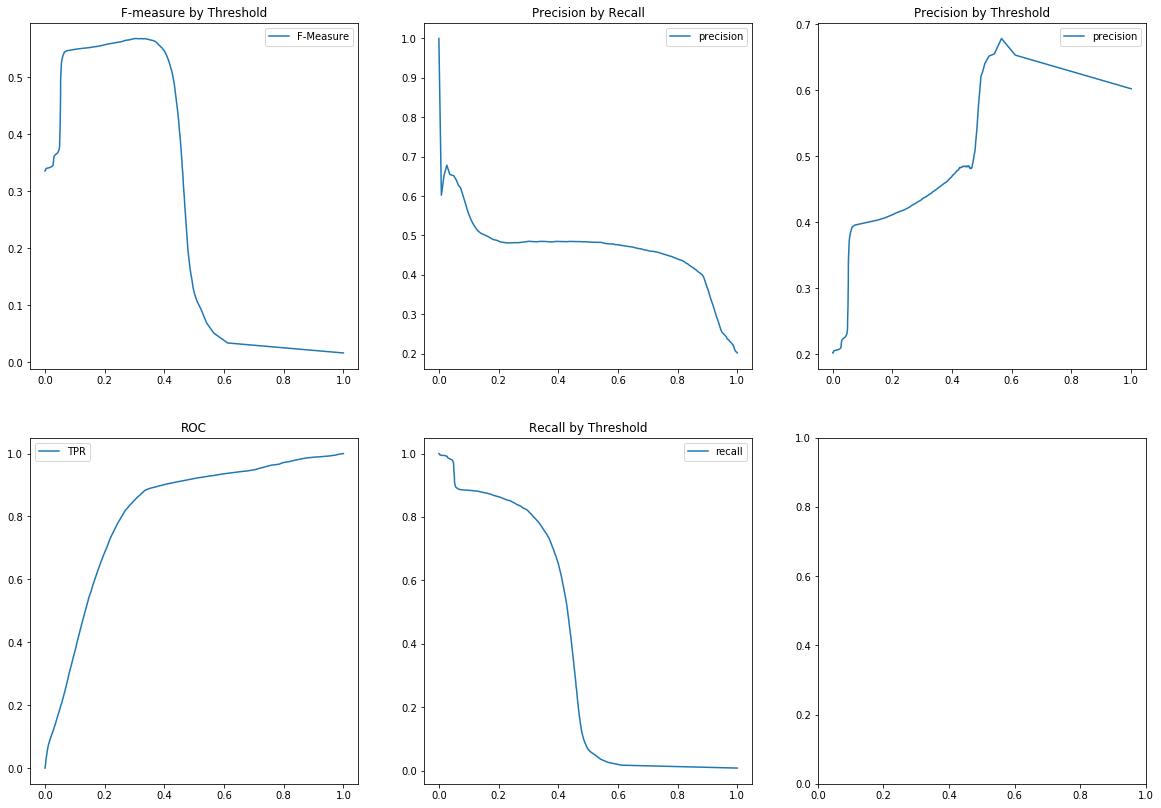

In [115]:
if crossValModel.bestModel.stages[-1].hasSummary:
    fig, axes = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(20, 14))
    summary = crossValModel.bestModel.stages[-1].summary
    
    
    print('The area under the curve is {}'.format(summary.areaUnderROC))
    attributes = []
    titles = ['F-measure by Threshold','Precision by Recall','Precision by Threshold', 'ROC', 'Recall by Threshold']
    attributes.append(summary.fMeasureByThreshold.toPandas())
    attributes.append(summary.pr.toPandas())
    attributes.append(summary.precisionByThreshold.toPandas())
    attributes.append(summary.roc.toPandas())
    attributes.append(summary.recallByThreshold.toPandas())
    #iterations = summary.totalIterations
    
    jdx = 0
    for idx, data_frame in enumerate(attributes):
        if idx % 3 == 0 and idx != 0:
            jdx+=1
        ax = axes[jdx,idx % 3]
        ax.plot(data_frame.columns[0],
                data_frame.columns[1],
                data=data_frame,                
               )
        ax.legend()
        ax.set_title(titles[idx])
    plt.show()
    
    


In [84]:
x = summary.fMeasureByThreshold.toPandas()
x

,threshold,F-Measure
0,1.000000,0.016460
1,0.611815,0.034012
2,0.565518,0.051437
3,0.541544,0.069272
4,0.523567,0.092275
5,0.509863,0.107057
6,0.501941,0.118728
7,0.496526,0.130531
8,0.492683,0.144016
9,0.488672,0.155828


In [72]:
summary.predictions.count()

96174

In [77]:
def test(x):
    print(*x)

In [78]:
test(summary.fMeasureByThreshold.toPandas())

threshold F-Measure
